# <font color ="blue"> Protein Expression in Mice with Down Syndrome </font>
### *BCG - Machine Learning Homework 2020*
**Veronica Erconi - veronica.erconi@mail.polimi.it**

## 1. Background
‹‹**Down syndrome (DS)** is a chromosomal abnormality associated with intellectual disability and
affecting approximately one in 1000 live births worldwide. It is due to an extra copy of the long arm of
**human chromosome 21 (Hsa21)** and the consequent increased level of expression, due to dosage, of
some subset of the genes it encodes. The overexpression of genes encoded by the extra copy of a nor-
mal chromosome in DS is believed to be sufficient to perturb normal pathways and normal responses
to stimulation, causing learning and memory deficits. The **memantine drug** is currently in use for
treatment of moderate to severe Alzheimer’s Disease (AD) and has been proposed for treatment of
learning deficits in DS. While memantine is known to modulate excitatory neurotransmission through
antagonizing activity of N-methyl-D-aspartate (NMDA) receptors, **little is known about its effects on
protein expression**, either alone or with learning paradigms.
In this dataset, **the effect of memantine on protein responses is studied in the partial trisomy mouse
model of DS, named Ts65Dn**. Untreated Ts65Dn mice fail to learn in context fear conditioning CFC
but if they are first injected with memantine, they learn successfully, i.e., learning is rescued. Protein
lysates were prepared from brains of 3 month old male Ts65Dn Down syndrome model mice and their
male littermate wild type controls, after training in context fear conditioning (CFC) with and without
injection with the drug memantine. The context-shock (CS) group of mice are placed in a novel cage,
allowed to explore for several minutes and then given a brief electric shock; normal, wildtype mice
learn to associate the novel context with the aversive stimulus and will freeze upon re-exposure to the
same cage. To control for the effects of the shock alone, a second group of mice, the shock-context
(SC) group, are placed in the novel cage, immediately given the electric shock, and then allowed to
explore; with these conditions, normal, wild type mice do not learn to associate the novel cage with
the shock and do not freeze upon re-exposure to the same cage. Unlike their wild type littermates, the
Ts65Dn CS group of mice fail to learn and do not freeze; **this learning impairment can be corrected,
however, if the Ts65Dn are injected with memantine prior to training**. To control for the effects of
injection alone, an additional CS group is also injected with saline (no drug). ››
— *Higuera, Clara, Katheleen J. Gardiner, and Krzysztof J. Cios. “Self-organizing feature maps
identify proteins critical to learning in a mouse model of down syndrome.” PloS one 10.6 (2015).*

In [17]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn
import random
import scipy
import imageio
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram
from scipy import stats
from scipy.stats import t, f
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, scale 
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
np.random.seed(0)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 2. Dataset Composition

The data set consists of the expression levels of 76 proteins/protein modifications that produced detectable
signals in the nuclear fraction of the cortex. The 77th column describe eight classes of mice based on features such as genotype, control (c) or trisomic (t), behavior, stimulated to learn (context-shock (CS)) or not (shock-context (SC)) and memantine injection (m) or saline (s). Samples have been split into **train** (367 samples x 76 protein expression+class) and **test** (245 samples x 75 protein expression+ class) sets. 
**NB.** A malfunctioning in the analysis procedure caused the measurements of the SOD1_N protein expression to be lost in all test samples.
Features are all real values and no data is missing, except from the SOD1_N feature on test samples.

In [10]:
#Select directory in which you have the dataset and on which you want to work
os.chdir("/home/veronica/bcg-2020/machine_learning/homework")
cwd = os.getcwd()
cwd

'/home/veronica/bcg-2020/machine_learning/homework'

In [11]:
##LOADING DATASETS

train_dataset= pd.read_csv(cwd + "/train.csv")
train_dataset.shape
train_dataset.head()

test_dataset= pd.read_csv(cwd + "/test.csv")
test_dataset.shape
test_dataset.head()

(367, 77)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,class
0,0.650511,1.158653,0.580172,2.230388,3.179675,0.533686,0.440101,5.033898,0.200985,1.589221,...,0.047287,0.337121,0.203356,0.191360,0.590874,0.112145,0.110109,0.160637,1.329248,t-CS-m
1,0.365907,0.651296,0.810468,2.597217,4.131603,0.537554,0.249235,6.099538,0.226362,1.700578,...,0.521112,0.419544,0.231619,0.393897,0.252572,0.352687,0.085545,0.328537,1.008023,t-SC-s
2,0.260145,0.397996,0.229522,2.643311,4.303648,0.268394,0.050916,3.130455,0.273792,2.534531,...,0.047407,0.053130,0.096325,0.257402,0.246015,0.203979,0.039188,0.008315,1.193634,c-SC-s
3,0.239489,0.271240,0.766816,1.872419,2.424971,0.322269,0.386791,2.351832,0.034265,0.472725,...,0.273651,0.162382,0.234056,0.180657,0.351388,0.103896,0.302341,0.166020,0.689970,c-CS-m
4,0.617112,0.751737,0.050685,2.356175,3.494138,0.506875,0.310644,3.855825,0.309879,1.033428,...,0.172488,0.014086,0.191145,0.149622,0.310434,0.151685,0.180055,0.383039,1.737274,t-CS-s


(245, 76)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,class
0,0.179263,0.066807,0.415744,1.689743,3.341121,0.544789,0.013569,4.505120,0.131921,1.145255,...,0.140915,0.230128,0.189588,0.314862,0.144272,0.302491,0.086637,0.042029,0.998893,c-SC-m
1,0.292189,0.721669,0.461519,2.405523,4.632695,0.070489,0.152357,3.563931,0.457679,1.798422,...,0.045180,0.544333,0.273302,0.397962,0.277610,0.155784,0.065486,0.093071,1.576650,c-SC-s
2,0.618632,0.880618,0.437260,2.339360,3.875806,0.129437,0.047842,4.920675,0.350683,1.492872,...,0.299862,0.075939,0.344712,0.131191,0.003888,0.035925,0.330201,0.035484,1.749580,c-CS-m
3,0.356012,0.646883,0.450320,2.478821,3.772100,0.122035,0.076693,3.225882,0.084315,1.195571,...,0.409750,0.079850,0.025022,0.102514,0.352965,0.080953,0.272696,0.218447,1.322880,t-SC-s
4,0.207957,0.402249,0.271787,1.596307,3.073973,0.106266,0.259618,2.467713,0.340771,0.891961,...,0.501047,0.009205,0.113849,0.186703,0.468138,0.206692,0.211410,0.114422,1.482459,c-SC-s


## 3. Preliminary Analysis

### 3.1 Training dataset description and feature visualization

The number of mice for each class of the training dataset was:
- 48 control mice, stimulated to learn, injected with saline
- 57 trisomy mice, stimulated to learn, injected with saline
- 36 control mice, stimulated to learn, injected with memantine
- 57 trisomy mice, stimulated to learn, injected with memantine
- 45 control mice, not stimulated to learn, injected with saline
- 58 trisomy mice, not stimulated to learn, injected with saline
- 28 control mice, not stimulated to learn, injected with memantine
- 38 trisomy mice, not stimulated to learn, injected with memantine

Summary piechart below to summarize visually 

([<matplotlib.patches.Wedge at 0x7f84c64e9e10>,
 [Text(0.49009181734500173, 0.9847893229373853, 'c-CS-s'),
  Text(-0.465591143538884, 0.9966066862399402, 't-CS-s'),
  Text(-1.0378885236276505, 0.3644000720664258, 'c-CS-m'),
  Text(-0.9864153348182582, -0.48681083311218953, 't-CS-m'),
  Text(-0.26062859289701534, -1.0686780322269762, 'c-SC-s'),
  Text(0.659110359269507, -0.8806665284337889, 't-SC-s'),
  Text(1.0797599779297906, -0.2100437812958483, 'c-SC-m'),
  Text(1.024424524644662, 0.4006923923741984, 't-SC-m')],
 [Text(0.26732280946091, 0.537157812511301, '13.1%'),
  Text(-0.25395880556666395, 0.5436036470399673, '15.5%'),
  Text(-0.5661210128878092, 0.19876367567259584, '9.8%'),
  Text(-0.5380447280826862, -0.2655331816975579, '15.5%'),
  Text(-0.14216105067109927, -0.5829152903056233, '12.3%'),
  Text(0.35951474141973105, -0.4803635609638848, '15.8%'),
  Text(0.5889599879617039, -0.11456933525228088, '7.6%'),
  Text(0.5587770134425428, 0.21855948674956274, '10.4%')])

(-1.1047366677392234,
 1.1030248527094813,
 -1.108854690357484,
 1.1077749707056477)

Text(0.5, 1.0, 'Mice classes in training dataset')

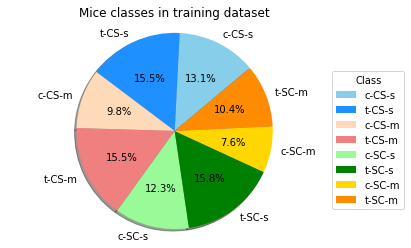

In [12]:
#class labels
labels = "c-CS-s", "t-CS-s", "c-CS-m", "t-CS-m", "c-SC-s", "t-SC-s", "c-SC-m", "t-SC-m"
#number of mice for each class
sizes = [48, 57, 36, 57, 45, 58, 28, 38]
#cold colors for saline, warm colors for memantine, light colors for controls and darker colors for trisomy
colors = ["skyblue", "dodgerblue", "peachpuff", "lightcoral", "palegreen", "g", "gold", "darkorange"]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=40)
ax.axis('equal')
ax.legend(labels,title="Class",loc=0, bbox_to_anchor=(0.7, 0.3, 0.5, 0.5))
ax.set_title("Mice classes in training dataset")
plt.show()

### 3.2 Features correlation and visualization
Features visualization, identify if features (i.e., protein expressions) are correlated and determine which features are most correlated with the target class. Using clustering,
study if there are structures in the data that allow samples from different classes to be easily identified. Compare the performance of different clustering algorithms on this data using the metrics
presented during the course.

A brief description of the distribution protein expressions for each class, containing mean, standard deviation, minimun, maximum and quantiles was calculated and plotted as a boxplot/violin/ boxed plot to visualize features.

### 3.3 General exploratory analysis - Clustering 

in order to identify eventual structures and relations in our input data, we performed a general exploratory analysis using different clustering algorithms: Agglomerative, K-means and DBSCAN.

In [14]:
#we devide our dataframe in inputs and external information about lables and convert to numpy
#first of all we generate the dictionary with key class name and associated number
conversion_dict = {"c-CS-s":0, "t-CS-s":1, "c-CS-m":2, "t-CS-m":3, "c-SC-s":4, "t-SC-s":5, "c-SC-m":6, "t-SC-m":7}
#we replace the strings representing class labels with integer values from 0 to 7
train_conv = train_dataset.replace({"class": conversion_dict})
#we devide our dataframe in inputs and external information about lables
feat_n = train_conv.drop("class", axis=1)
#and normalize
feat = preprocessing.normalize(feat_n)
cl = train_conv["class"]
print ("Rows, columns of input dataframe and class dataframe are: ", feat.shape, ",", cl.shape)

Rows, columns of input dataframe and class dataframe are:  (367, 76) , (367,)


In [21]:
#definition of functions useful to perform dendrogram and plotting the result of the clustering
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.affinity)
    
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-6
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram
    ddata = dendrogram(Z, ax=ax, **kwargs) 
    
    # Annotate nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:,2] == y)[0][0]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')
    
    return fig, ax

def plot3d(X, labels):
    # Set matplotlib as interactive
    # &matplotlib inline
    # Set matplotlib to generate static images
    #%matplotlib notebook
    # This import is required to set up the 3D environment
    
    pca = PCA(n_components=3)
    X = pca.fit_transform(X)
    
    unique_labels = np.unique(labels)
    # Convert negative values (outliers) into positive
    labels = labels.copy()
    labels += np.abs(unique_labels.min())
    nlabels = len(unique_labels)
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    # Define color mappings
    col = ("bwr" if nlabels <= 2 else
          ("Dark2" if nlabels > 2 & nlabels <= 8 else
           "hsv"))
    cmap = plt.cm.get_cmap(col)
    smap = cm.ScalarMappable(
              norm=mcolors.Normalize(unique_labels.min(), unique_labels.max()+1), 
              cmap=cmap)
    # Plot the 3d coordinates 
    ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], c=labels, cmap=cmap)
    # Plot a color bar on the right
    plt.colorbar(mappable=smap, label='digit label', ticks=range(nlabels))
    
    from sklearn.metrics.pairwise import pairwise_distances

def sorted_sim(sim, y_pred):
    idx_sorted = np.argsort(y_pred)
    # Sort the rows
    sim = sim[idx_sorted]
    # Sort the columns
    sim = sim[:, idx_sorted]
    
    return sim

def wss(X, y_pred, metric):
    ncluster = np.unique(y_pred).shape[0]
    err = 0
    for k in range(ncluster):
        # All the points of this cluster
        X_k = X[y_pred == k]
        # Distances of all points within the cluster
        dist_mat = pairwise_distances(X_k, metric=metric)
        # Select the lower triangular part of the matrix
        triu_idx = np.tril_indices(dist_mat.shape[0], k=1)
        err += (dist_mat[triu_idx] ** 2).sum()
    
    return err

def bss(X, y_pred, metric):
    ncluster = np.unique(y_pred).shape[0]
    # Sort the distance matrix (as we did for the simiarity)
    dist_mat = pairwise_distances(X, metric=metric) ** 2
    dist_mat = sorted_sim(dist_mat, y_predict)
    y_sort = np.sort(y_pred)
    
    err = 0
    for k in range(ncluster):
        kidx = np.where(y_sort == k)[0]
        start, end = kidx[0], kidx[-1]
        err += dist_mat[start:end, end+1:].sum()
    
    return err
    
def get_Ncounts(y_predict, y_true, k, j=None):
    N = y_true.shape[0]
    Nk_mask = y_predict == k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    if j is not None:
        Nj_mask = y_true == j
        Nj = Nj_mask.sum()
        Nkj = np.logical_and(Nj_mask, Nk_mask).sum()
    return N, Nk, Nj, Nkj

def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)
    
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

##### 3.3.1 Hierarchical bottom up clustering

We try to perform the agglomerative clustering with Pearson's Correlation metrics between points and different linkages to obtain the best dendrogram result cutting the dendrogram to obtain eight clusters
based on our knowledge about the dataset.

Text(0.5, 1.0, 'single')

Text(0.5, 1.0, 'average')

Text(0.5, 1.0, 'complete')

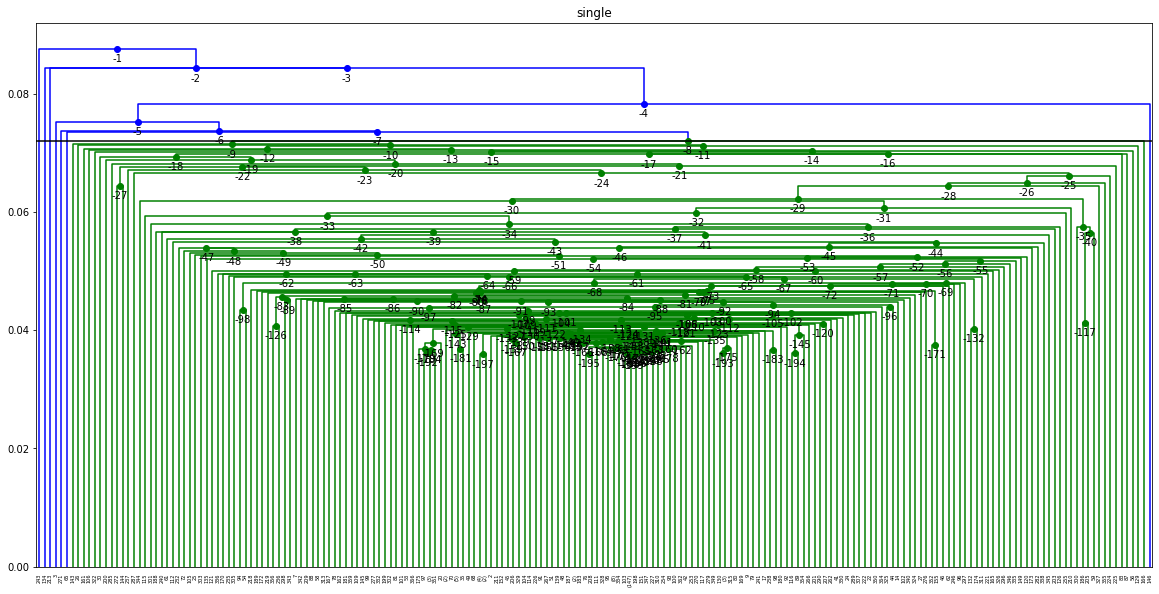

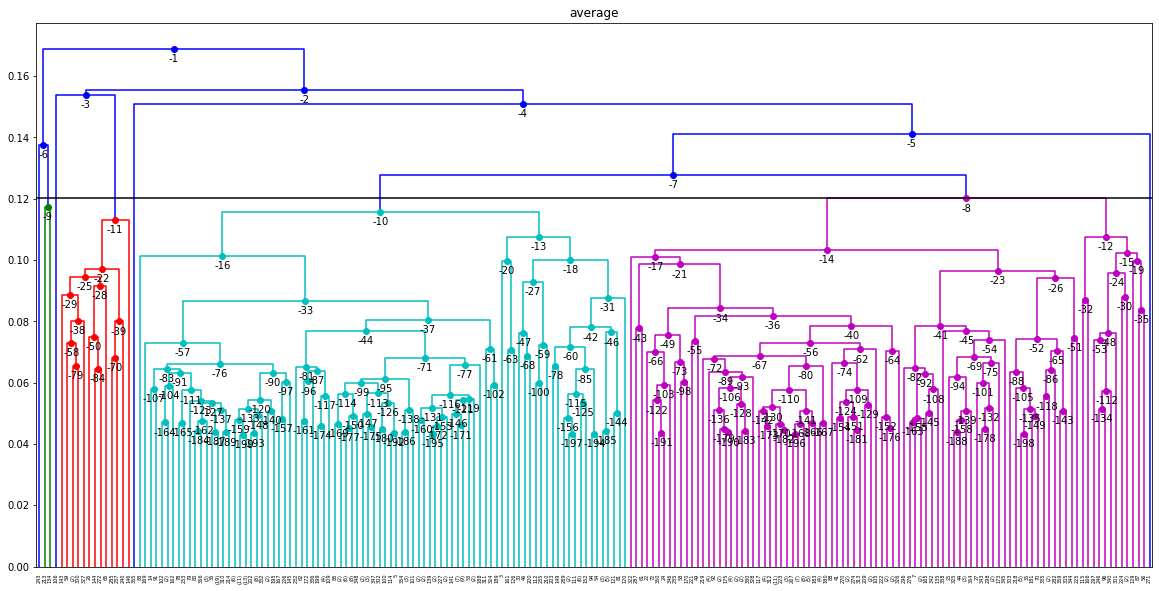

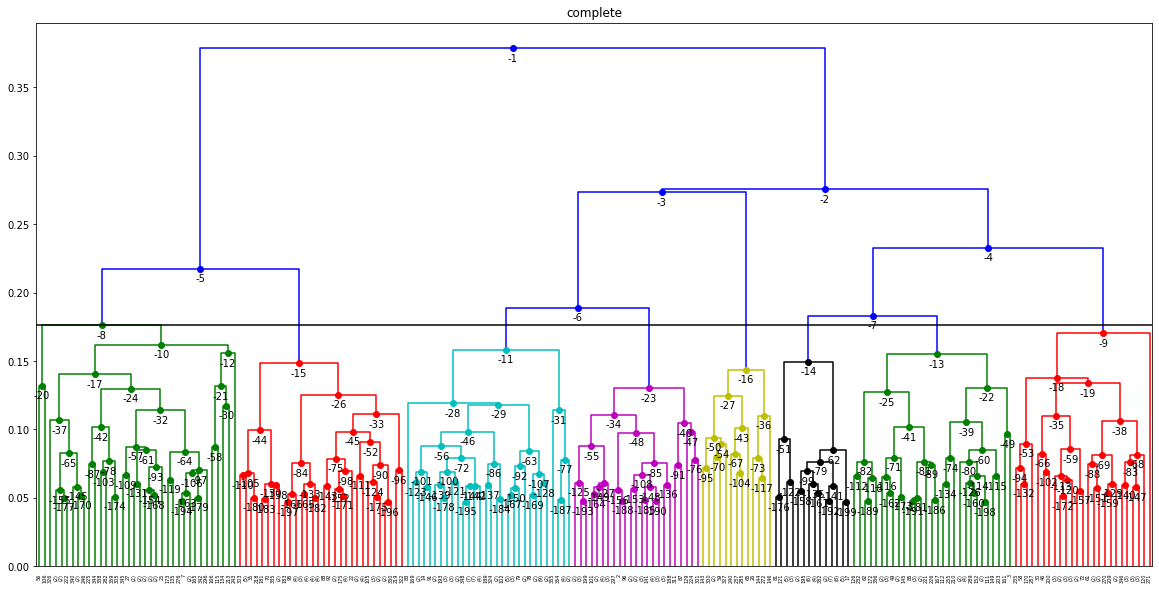

In [18]:
#we tried to check which linkage seemed more suitable for our dataset
methods = ['single', 'average', 'complete']

for method in methods:
    Z = linkage(feat, metric='correlation', method=method, optimal_ordering=True)
    fig, ax = plot_dendrogram(Z=Z, X=feat, truncate_mode='lastp', 
                              p=200, n_clusters=8)
    ax.set_title(method)

Different linkages resulted into different dendrograms.
In particular, dendrogram obtained with complete linkage is the one that looks less chaotic and we decided to select this one for our agglomerative clustering


(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84c521c110>)

Total Purity: 0.4850136238613725


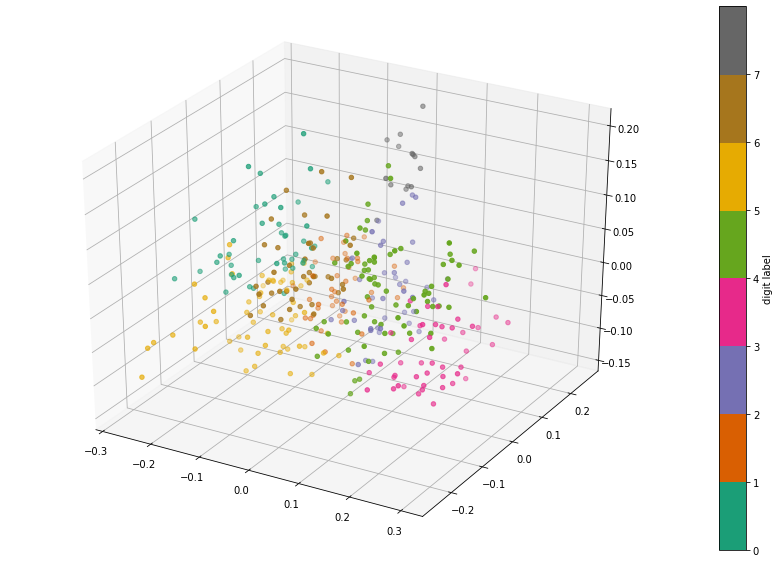

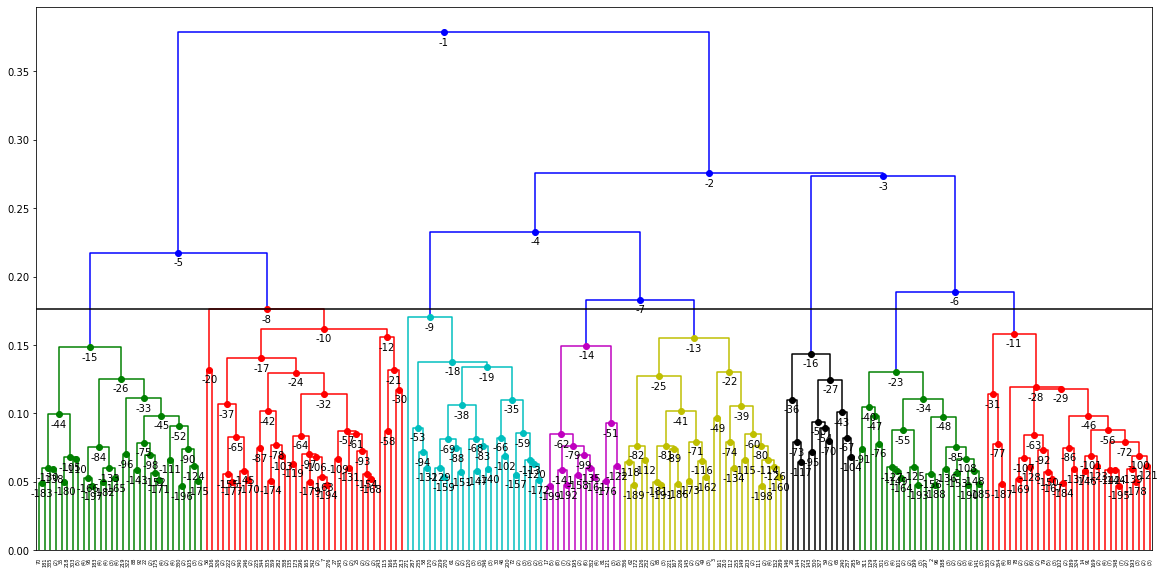

In [26]:
#Agglomerative clustering results graphical results
distance_threshold=None#270
n_clusters=8

model8 = AgglomerativeClustering(n_clusters=n_clusters, 
                                distance_threshold=distance_threshold, 
                                affinity='correlation', linkage='complete')

y_predict = model8.fit_predict(feat)
plot3d(feat, labels=y_predict)
plot_dendrogram(model=model8, X=feat, truncate_mode='lastp', p=200, 
                n_clusters=n_clusters, color_threshold=distance_threshold)
TP = tot_purity(y_predict, cl)
print ("Total Purity:", TP)

The goodness of clustering algorithm was evaluated as total purity, which is given by the mean of the maximum precision of the class of the generated clusters.
Agglomerative clustering purity resulted of 0.485, which does not represent an excellent result.

Text(0.5, 1.0, 'Elbow Method Aglomerative clustering')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'SEE')

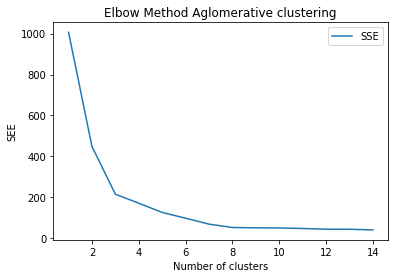

In [24]:
#Elbow method evaluation 
wss_list, bss_list, sil_list = [], [], []
clus_list = list(range(1, 15))

for nc in clus_list:
    model = AgglomerativeClustering(n_clusters=nc,
                                    affinity='correlation', 
                                    linkage='complete')

    y_predict = model.fit_predict(feat)
    
    wss_list.append(wss(feat, y_predict, 'correlation'))
    bss_list.append(bss(feat, y_predict, 'correlation'))
    if nc > 1:
        sil_list.append(silhouette_score(feat, y_predict, metric='correlation'))
plt.title("Elbow Method Aglomerative clustering")
plt.plot(clus_list, wss_list, label='SSE')
plt.xlabel("Number of clusters")
plt.ylabel("SEE")
#plt.plot(clus_list, bss_list, label='BSS')
plt.legend()
plt.show()

Elbow method was used to evaluate wether the number of clusters we have chosen based on our knowledge present low sum of squared error (SSE).
The graph evaluation was made remembering that the higher the number clusters the lower the SSE, for this reason we searched the point...(continue)

##### 3.3.2 K-Means clustering

We tried to perform the k-means partitioning clustering setting again 8 number of clusters. 

Total Purity: 0.4986376020682756


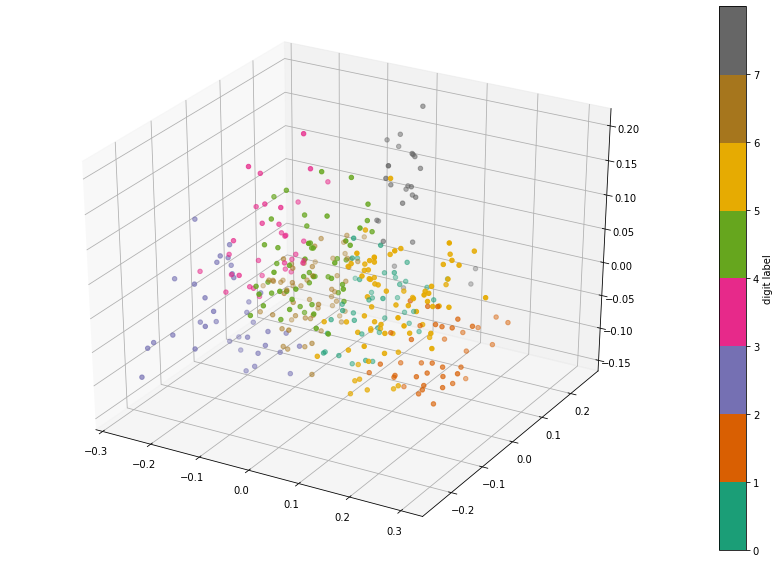

In [31]:
modelk8 = KMeans(n_clusters=8, init='random', random_state=0)             
y_predictk8 = modelk8.fit_predict(feat)
plot3d(feat, labels=y_predictk8)
TP = tot_purity(y_predictk8, cl)
print ("Total Purity:", TP)

With K-means algorithm we obtained a slightly better purity compared to the one provided by the bottom up algorithm. However, since the initialization highly influences the clustering, we decided to perform k-means starting from centroids obtained with different methods

In [32]:
# K-Means++ initialization
model = KMeans(n_clusters=8, init='k-means++', random_state=0) 
y_predict = model.fit_predict(feat)
TP = tot_purity(y_predict, cl)
print ("K-Means ++ Initialization Total Purity:", TP)
# Hierarchical
hmodel = AgglomerativeClustering(n_clusters=8, 
                                distance_threshold=distance_threshold, 
                                affinity='correlation', linkage='complete')
y_predicth = hmodel.fit_predict(feat)
centroids = np.stack([feat[y_predicth == k].mean(0) for k in range(8)])
model = KMeans(n_clusters=8, init=centroids, n_init=1, random_state=0) 
y_predict = model.fit_predict(feat)
TP = tot_purity(y_predict, cl)
print ("Initialization Hierarchical approach Total Purity:", TP)

K-Means ++ Initialization Total Purity: 0.4877384195104608
Initialization Hierarchical approach Total Purity: 0.49591280642591246


Even if we observed slightly lower purity values with these two initialization methods their result is more trustable.

##### 3.3.3 Density based clustering: DBSCAN

Finally, we tried to perform clustering based on density.(The downside in this case is due to the fact that the performance could not be optimal in case of not uniform densty.)

In this case, we do not need to provide a desired number of clusters or distance/linkage metrics but we need to find epsilon, which is the maximum radius that defines the neighborhood of a point and the minimum number of points required to say that a point is in an high density space.
To estimate these hyperparameters we perform gridsearch cross-validation as follows:

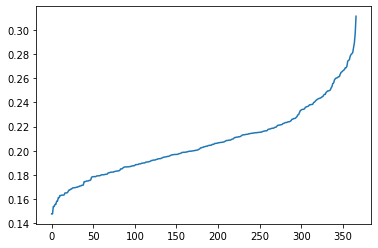

In [33]:
#identification of eps thanks to the k-nearest neighbour graph
#establish an arbitrary number of k neighbors
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(feat)
distances, indices = nbrs.kneighbors(feat)
#sort points based on ascending distance 
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#The optimal value for epsilon is the distance just before the change in slope of the curve
#We decided to approximate at 0.23

In [ ]:
# We redefined make_scorer function to use fit_predict() of DBSCAN instead of predict() method that would be required as default
def make_scorer(metric):
    def scorer(estimator, X, y):
        y_pred = estimator.fit_predict(X)
        return metric(y_pred, y)
    return scorer